In [38]:
import requests
import json
import pandas as pd
from google.transit import gtfs_realtime_pb2
from google.protobuf.json_format import MessageToDict

import time
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import contextily as ctx
from IPython.display import clear_output

In [39]:
def get_data():
    # Get data from Entur API
    response = requests.get("https://api.entur.io/realtime/v1/gtfs-rt/vehicle-positions?datasource=KOL")
    
    # Parse the data to json format
    feed = gtfs_realtime_pb2.FeedMessage()
    feed.ParseFromString(response.content)

    # Write the data to a file
    with open("vehicle_positions.json", "w") as file:
        json.dump(MessageToDict(feed), file, indent=4)
    
    # Return the filepath
    return "vehicle_positions.json"

In [40]:
def read_file(filepath):
    with open(filepath, "r") as file:
        return json.load(file)

In [41]:
def plot_on_map():
    dataset = read_file(get_data())
    #dataset = read_file("vehicle_positions.json")

    fixed_dataset = [x["vehicle"] for x in dataset["entity"]]

    df = pd.DataFrame(fixed_dataset)
    positional_df = df["position"].apply(pd.Series, index=["latitude", "longitude"])

    geometry = [Point(xy) for xy in zip(positional_df['longitude'], positional_df['latitude'])]
    gdf = GeoDataFrame(df, geometry=geometry) 
    # Set the coordinate reference system to WGS84 (EPSG:4326)
    gdf = gdf.set_crs(epsg=4326)

    # Convert to Web Mercator (EPSG:3857) for contextily
    gdf = gdf.to_crs(epsg=3857)

    # Clear the current output
    clear_output(wait=True)

    # Plot the data
    ax = gdf.plot(figsize=(10, 6), marker='o', color='red', markersize=5)

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    # Set the limits to the relevant region
    ax.set_xlim(gdf.total_bounds[0], gdf.total_bounds[2])
    ax.set_ylim(gdf.total_bounds[1], gdf.total_bounds[3])

    plt.pause(15)
    plt.close('all')

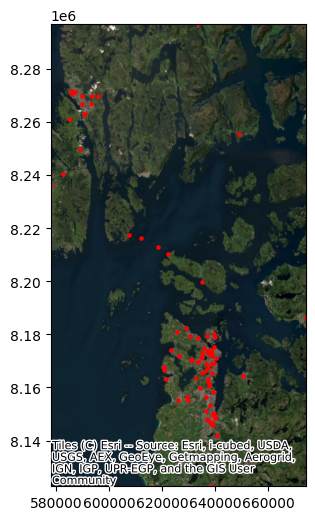

KeyboardInterrupt: 

In [42]:
while True:
    plot_on_map()